# Assignment 2: Clustering California Housing with K-means

## Introduction

This notebook was developed during the coursework of CS 4774 Machine Learning in the Department of Computer Science at the University of Virginia.

I will attempt to cluster the California Housing by implementing and analyzing a k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid.


---
## Step 1: Processing the Data

I will download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** This will be accomplished in the below cels

In [ ]:
from pandas.plotting import scatter_matrix # optional
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from google.colab import files
import io

uploaded = files.upload()
housing = pd.read_csv(io.BytesIO(uploaded['housing.csv']))

housing.head(10)



Saving housing.csv to housing.csv


longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY
5    -122.25     37.85  ...            269700.0         NEAR BAY
6    -122.25     37.84  ...            299200.0         NEAR BAY
7    -122.25     37.84  ...            241400.0         NEAR BAY
8    -122.26     37.84  ...            226700.0         NEAR BAY
9    -122.25     37.84  ...            261100.0         NEAR BAY

[10 rows x 10 columns]

In [ ]:
# Provide a quick summary of the data including name of features, count, and type
housing.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# View the counts of each value in the "ocean_proximity" feature
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
# Provide some basic statistics about the dataset
housing.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

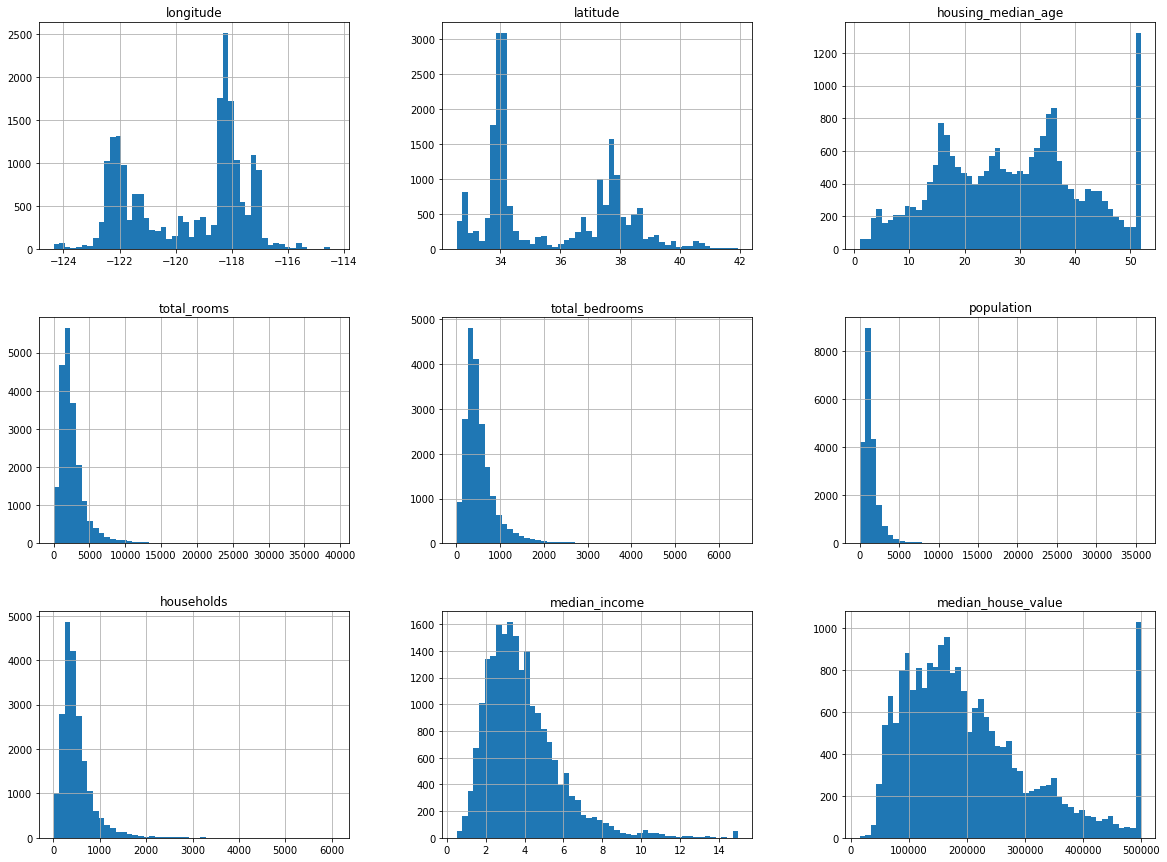

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()
#save_fig("attribute_histogram_plots")


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into train set (80%) and test set (20%)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


In [ ]:
print( train_set.shape )
print( test_set.shape )

(16512, 10)
(4128, 10)


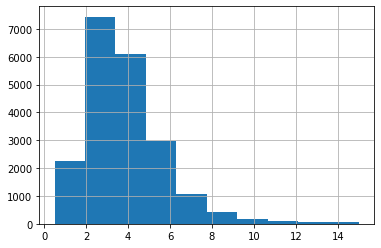

In [ ]:
housing["median_income"].hist()

In [ ]:
# Since this histogram is "tail heavy" (extends much farther to the right from the median and to the left)
# I will try to transform this atrribute to have a more bell-shaped distribution
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

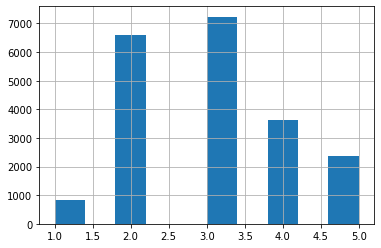

In [ ]:
housing["income_cat"].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace=True)

In [ ]:
# Make a copy of the stratified train set
housing = strat_train_set.copy()

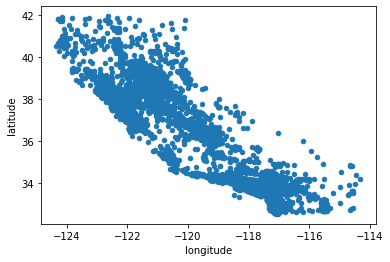

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")
# save_fig("bad_visualization_plot")

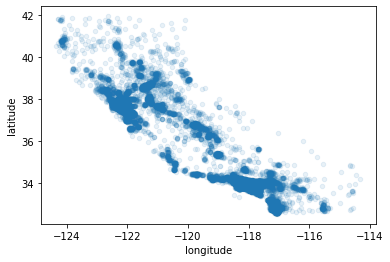

In [ ]:
# Add alpha channel for transparent so that the plot is less crowded.
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
# save_fig("better_visualization_plot")

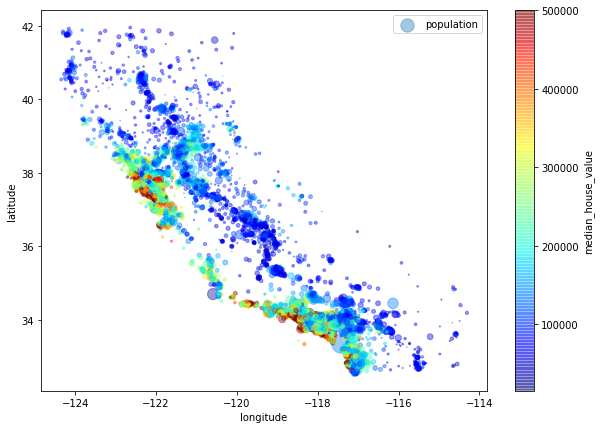

In [ ]:
# Incorporate the population into the circle size
# Add color (jet map) for the value of the housing
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
# save_fig("housing_prices_scatterplot")

In [ ]:
# Create the features and labels for training
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [ ]:
# Check to see if there's any missing value in the data with .isnull()
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

longitude  latitude  ...  median_income  ocean_proximity
1606     -122.08     37.88  ...         2.9330         NEAR BAY
10915    -117.87     33.73  ...         3.4193        <1H OCEAN
19150    -122.70     38.35  ...         3.7813        <1H OCEAN
4186     -118.23     34.13  ...         4.2891        <1H OCEAN
16885    -122.40     37.58  ...         6.3580       NEAR OCEAN

[5 rows x 9 columns]

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
Index: []

In [ ]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [ ]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [ ]:
X = imputer.transform(housing_num)
print(X)

[[-1.2146e+02  3.8520e+01  2.9000e+01 ...  2.2370e+03  7.0600e+02
   2.1736e+00]
 [-1.1723e+02  3.3090e+01  7.0000e+00 ...  2.0150e+03  7.6800e+02
   6.3373e+00]
 [-1.1904e+02  3.5370e+01  4.4000e+01 ...  6.6700e+02  3.0000e+02
   2.8750e+00]
 ...
 [-1.2272e+02  3.8440e+01  4.8000e+01 ...  4.5800e+02  1.7200e+02
   3.1797e+00]
 [-1.2270e+02  3.8310e+01  1.4000e+01 ...  1.2080e+03  5.0100e+02
   4.1964e+00]
 [-1.2214e+02  3.9970e+01  2.7000e+01 ...  6.2500e+02  1.9700e+02
   3.1319e+00]]


In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

longitude  latitude  ...  households  median_income
1606     -122.08     37.88  ...       626.0         2.9330
10915    -117.87     33.73  ...       499.0         3.4193
19150    -122.70     38.35  ...       397.0         3.7813
4186     -118.23     34.13  ...       294.0         4.2891
16885    -122.40     37.58  ...       480.0         6.3580

[5 rows x 8 columns]

In [ ]:
# Isolate ocean proximity to its own variable
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
# OrdinalEncoder encodes consecutive numbers for the categories (5 categories --> 0,1,2,3,4)
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# When set to false, that feature will not be added --> so here it adds two features only
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)


print(housing.shape)
print(housing_prepared.shape)

(16512, 9)
(16512, 13)


In [ ]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

- - -
## Step 2: K-Means Implementation

This will be my own implementation of the K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In this case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** An implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that the functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [ ]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
from math import *
from random import randrange

def k_means(data, k, n, p):
    centroids = get_random_centroids(data, k)
    prev_centroids = None
    while not is_done(prev_centroids, centroids):
        prev_centroids = centroids
        labels = get_labels(data, centroids, n, p)
        centroids = get_centroids(data, centroids, labels)
    labels = get_labels(data, centroids, n, p)
    labels_column = get_labels_column(labels, centroids)
    values = []
    values.append(labels_column)
    values.append(centroids)
    values.append(labels)
    return [labels_column, centroids, labels]

def is_done(prev_centroids, centroids):
    isSame = 0
    if (prev_centroids != None):
      for i in prev_centroids:
        for j in centroids:
          if (i == j).all():
            isSame += 1
      if isSame == len(centroids):
        return True
    return False

def get_labels(data, centroids, n, p):
    labels = []
    min_distance = 0
    for i in data:
      init = False
      temp_label = None
      for j in centroids:
        if (init == False):
          min_distance = distance_calculation(n, i, j, p)
          temp_label = j
          init = True
        temp_distance = distance_calculation(n, i, j, p)
        if (temp_distance < min_distance):
          min_distance = temp_distance
          temp_label = j
      labels.append(temp_label)
    return labels

def get_labels_column(labels, centroids):
    labels_column = []
    for i in labels:
      for j in range(len(centroids)):
        if (i == centroids[j]).all():
          labels_column.append(j)
    return labels_column

def distance_calculation(n, x, y, p):
  if n == 1:
    return minkowski_distance(x, y, p)
  elif n == 2:
    return manhattan_distance(x, y)
  elif n == 3:
    return euclidean_distance(x, y)
  elif n == 4:
    return sup_distance(x, y)
  return None

def get_centroids(data, centroids, labels):
    mean_centroids = []
    for i in centroids:
      total = 0
      temp_mean = None
      first_flag = 0
      for j in range(len(data)):
        if (i == labels[j]).all():
          if first_flag == 0:
            temp_mean = data[j]
            first_flag = 1
          else:
            temp_mean = np.add(data[j], temp_mean)
          total += 1
      if (total == 0):
        temp_mean = get_random_centroids(data, 1)
      else:
        temp_mean = np.divide(temp_mean, total)
      mean_centroids.append(temp_mean)
    return mean_centroids

def get_std_dev(data, centroids, labels):
    std_dev_centroids = []
    for i in centroids:
      total = 0
      temp_std_dev = None
      first_flag = 0
      for j in range(len(data)):
        if (i == labels[j]).all():
          if first_flag == 0:
            temp_std_dev = data[j]
            first_flag = 1
          else:
            temp_std_dev = np.add(np.power(np.subtract(data[j], i), 2), temp_std_dev)
          total += 1
      temp_std_dev = np.divide(temp_std_dev, total)
      temp_std_dev = np.sqrt(temp_std_dev)
      std_dev_centroids.append(temp_std_dev)
    return std_dev_centroids

def get_random_centroids(data, num_centroids_k):
    num_rows = len(data)
    centroids = []
    for i in range(num_centroids_k):
      r = randrange(num_rows)
      centroids.append(data[(r)])
    return centroids

def get_sse(data, centroids):
  sse_centroids = []
  sum = 0
  for i in centroids:
    sum = 0
    for j in data:
      sum = np.add(np.power(np.abs(j - i), 2), sum)
    sse_centroids.append(sum)
  return sse_centroids

def minkowski_distance(x, y, p):
  n = len(x)
  sum = 0
  if (n != len(y)):
    return None
  for i in range(len(x)):
    sum += pow(abs(x[i] - y[i]), p)
  return sum**(1/float(p)) # shorthand found at https://stackoverflow.com/a/

def manhattan_distance(x, y):
  return minkowski_distance(x, y, 1)

def euclidean_distance(x, y):
  return minkowski_distance(x, y, 2)

def sup_distance(x, y):
  n = len(x)
  max = 0
  max_temp = 0
  if (n != len(y)):
    return None
  for i in range(len(x)):
    max_temp = abs(x[i] - y[i])
    if (max_temp > max):
      max = max_temp
  return max

def define_centroids(data, num_centroids):
  num_rows = len(data)
  centroids = []
  for i in range(num_centroids):
    r = randrange(num_rows)
    centroids.append(data[(r)])
    centroids.append(r)
  return centroids


- - -
## Step 3: Clustering Housing Into Regions

Now that I have implemented the K-Means as the clustering algorithm, I will apply the algorithm for k=2 clusters to see if I can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. I should get a plot that looks roughly in the shape of California. Using the cluster means and std. deviations as representative values in the cluster, what can be said about the clusters that were found? How do they compare with what is known about cities and areas in California? What can be attributed to explaing the gaps?

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When I change k, does any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


In [ ]:
housing_prepared_df = pd.DataFrame(housing_prepared, columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'])
housing_df = housing_prepared_df

The following 18 cells will run the minkowski distance with a p value of 3, the value was chosen based off of the accuracy of the k = 2 trial (but it could be any p value). A number of interesting patterns occur, primarily the sparseness of data points in a cluster on the inland cities compared the the coast (Assuming the data collection is evenly distributed and representative of the state). As the number of clusters approached 10, it was incredibly insightful to see the nuance of north and south remain the same, but coastal cities remain in a distinct cluster. This higher level of nuance is visually important to the study, as it highlights the expensive housing threshold many of the districts in the coastal cities.

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_1_2 = k_means(housing_prepared, 2, 1, 3)

[array([3.48952228e+04, 3.57608706e+04, 1.66157259e+04, 1.71125819e+04,
       1.73824392e+04, 1.77363970e+04, 1.74061704e+04, 1.65613470e+04,
       5.22737810e+03, 3.92929324e+03, 2.00000000e+00, 2.03090708e+03,
       1.86907230e+03]), array([2.51352980e+04, 2.55413606e+04, 1.65606563e+04, 1.67937241e+04,
       1.69203101e+04, 1.70863465e+04, 1.69314421e+04, 1.65351479e+04,
       4.61288500e+03, 3.74656653e+03, 1.99987139e+00, 1.82358014e+03,
       1.85936170e+03])]
[array([0.47228499, 0.46904597, 1.04800051, 0.57609241, 0.58450435,
       0.56086473, 0.60747797, 0.98756692, 0.38077456, 0.49873923,
       0.        , 0.44166342, 0.29369768]), array([0.49736567, 0.43468242, 0.96175097, 1.18979649, 1.17902545,
       1.17639019, 1.17033912, 1.00662027, 0.48483663, 0.41410233,
       0.01428426, 0.08054787, 0.35850596])]
[array([-1.05514218,  1.07969922,  0.07925811, -0.19071563, -0.22959867,
       -0.27230856, -0.23270746, -0.05466766,  0.17595352,  0.46305125,
        0.        ,

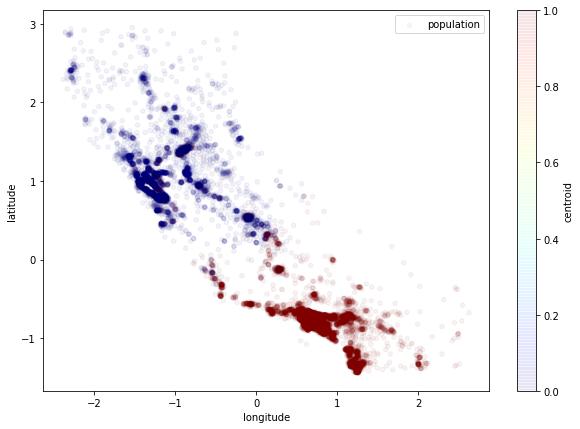

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_1_2[1], values_1_2[2])
sse = get_sse(housing_prepared, values_1_2[1])
housing_df['centroid'] = values_1_2[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_1_2[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.05, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_1_3 = k_means(housing_prepared, 3, 1, 3)

[array([3.46775739e+04, 3.56818465e+04, 1.66345596e+04, 1.73247574e+04,
       1.76312937e+04, 1.79757723e+04, 1.76912969e+04, 1.65732274e+04,
       5.24511215e+03, 3.94352554e+03, 2.00000000e+00, 2.01966894e+03,
       1.86767693e+03]), array([1.73533471e+04, 1.72288612e+04, 3.02027790e+04, 9.21714800e+04,
       9.73159880e+04, 8.70147396e+04, 9.74474380e+04, 1.70287206e+04,
       4.09175739e+03, 3.59303446e+03, 2.00000000e+00, 1.66428760e+03,
       1.85743503e+03]), array([2.65936370e+04, 2.72718606e+04, 1.67054324e+04, 1.74570291e+04,
       1.73315619e+04, 1.69626358e+04, 1.72946852e+04, 1.65151014e+04,
       4.74916087e+03, 3.82335332e+03, 1.99999034e+00, 1.84700000e+03,
       1.86470704e+03])]
[array([0.47622926, 0.46849012, 1.0471997 , 0.51365521, 0.526017  ,
       0.51843604, 0.539937  , 0.9863232 , 0.37904571, 0.49895229,
       0.        , 0.44047337, 0.29547318]), array([0.95832911, 0.89609854, 0.72492837, 1.69448938, 1.52491314,
       1.68076576, 1.50297232, 0.99308

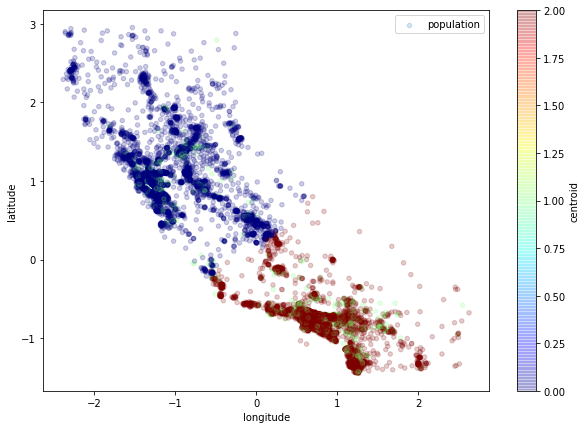

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_1_3[1], values_1_3[2])
sse = get_sse(housing_prepared, values_1_3[1])
housing_df['centroid'] = values_1_3[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_1_3[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_1_4 = k_means(housing_prepared, 4, 1, 3)

[array([3.52784369e+04, 3.66452211e+04, 1.67219550e+04, 1.73754328e+04,
       1.75056914e+04, 1.79069271e+04, 1.75730626e+04, 1.71481643e+04,
       5.32802662e+03, 3.97524123e+03, 2.00000000e+00, 2.05115823e+03,
       1.87123933e+03]), array([2.11100437e+04, 2.23780951e+04, 2.23527381e+04, 1.67691307e+04,
       1.68285380e+04, 1.67261725e+04, 1.67786266e+04, 4.55446233e+04,
       4.62242005e+03, 3.83696531e+03, 2.00000000e+00, 1.75120865e+03,
       1.85915332e+03]), array([1.72694574e+04, 1.70773984e+04, 3.04358311e+04, 1.03891185e+05,
       1.12698332e+05, 9.89602090e+04, 1.12521453e+05, 1.66083944e+04,
       4.08048177e+03, 3.60867277e+03, 2.00000000e+00, 1.66093687e+03,
       1.86324889e+03]), array([2.63752310e+04, 2.67381460e+04, 1.85789739e+04, 1.84179160e+04,
       1.74068107e+04, 1.69299722e+04, 1.73796107e+04, 1.92301524e+04,
       4.64388873e+03, 3.77012573e+03, 2.00041589e+00, 1.84700000e+03,
       1.86659813e+03])]
[array([0.46067923, 0.46560407, 1.04276349, 0.5

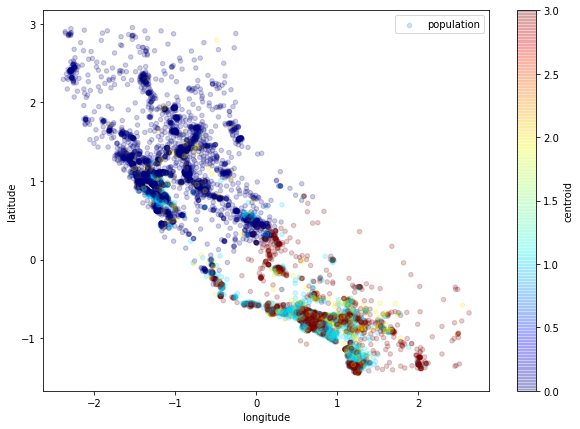

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_1_4[1], values_1_4[2])
sse = get_sse(housing_prepared, values_1_4[1])
housing_df['centroid'] = values_1_4[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_1_4[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_1_5 = k_means(housing_prepared, 5, 1, 3)

[array([3.13844898e+04, 3.59733449e+04, 2.47115999e+04, 1.65126126e+04,
       1.65512000e+04, 1.66177091e+04, 1.65635048e+04, 1.65262665e+04,
       4.82407850e+03, 4.67414290e+03, 2.00000000e+00, 1.64306653e+03,
       1.90189477e+03]), array([2.59763847e+04, 2.66401417e+04, 2.19866871e+04, 1.72739811e+04,
       1.68655574e+04, 1.68951071e+04, 1.68768754e+04, 2.41537263e+04,
       4.59652142e+03, 3.79704863e+03, 2.00000000e+00, 1.81457310e+03,
       1.87390643e+03]), array([2.59350166e+04, 2.65352478e+04, 2.17094935e+04, 2.00728882e+04,
       1.90095175e+04, 1.80067880e+04, 1.89355771e+04, 1.88812803e+04,
       4.78746814e+03, 3.82029402e+03, 2.00098946e+00, 1.84700000e+03,
       1.85903876e+03]), array([3.93495521e+04, 3.51079566e+04, 3.48375656e+04, 1.96031227e+04,
       1.95537424e+04, 2.03419702e+04, 1.95661479e+04, 1.75623856e+04,
       5.87661347e+03, 3.58592997e+03, 2.00000000e+00, 3.45055945e+03,
       1.85126245e+03]), array([1.71868342e+04, 1.70025284e+04, 3.229321

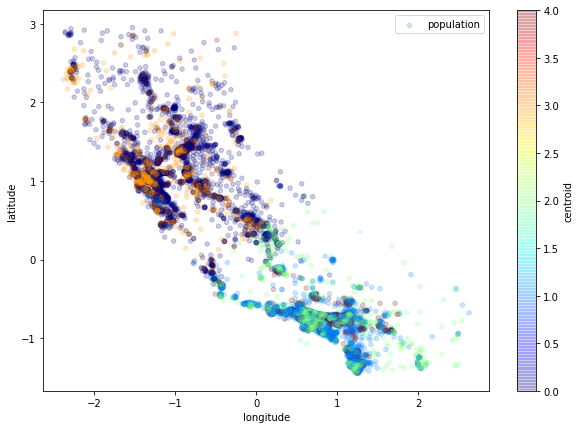

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_1_5[1], values_1_5[2])
sse = get_sse(housing_prepared, values_1_5[1])
housing_df['centroid'] = values_1_5[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_1_5[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_1_6 = k_means(housing_prepared, 6, 1, 3)

[array([1.95481507e+04, 1.95106361e+04, 2.48974268e+04, 3.48438128e+04,
       4.13900446e+04, 3.86079390e+04, 4.13897371e+04, 1.66182082e+04,
       4.19411033e+03, 3.59398435e+03, 2.00000000e+00, 1.71338584e+03,
       1.85088878e+03]), array([2.67065908e+04, 2.70964860e+04, 1.88148125e+04, 1.92014569e+04,
       1.83346691e+04, 1.76335504e+04, 1.83053690e+04, 1.86991618e+04,
       4.66304950e+03, 3.79051100e+03, 2.00058275e+00, 1.84700000e+03,
       1.86933889e+03]), array([3.95419601e+04, 3.48978265e+04, 3.57062520e+04, 1.93787610e+04,
       1.93201318e+04, 2.00816575e+04, 1.92878359e+04, 1.76039329e+04,
       5.82947165e+03, 3.58661819e+03, 2.00000000e+00, 3.54800391e+03,
       1.85120044e+03]), array([3.07787792e+04, 3.65245305e+04, 2.50955987e+04, 1.66431246e+04,
       1.68143783e+04, 1.70054955e+04, 1.68965591e+04, 1.68190148e+04,
       4.95862284e+03, 5.01853793e+03, 2.00000000e+00, 1.64046133e+03,
       1.91125389e+03]), array([2.01971248e+04, 2.20077948e+04, 1.839774

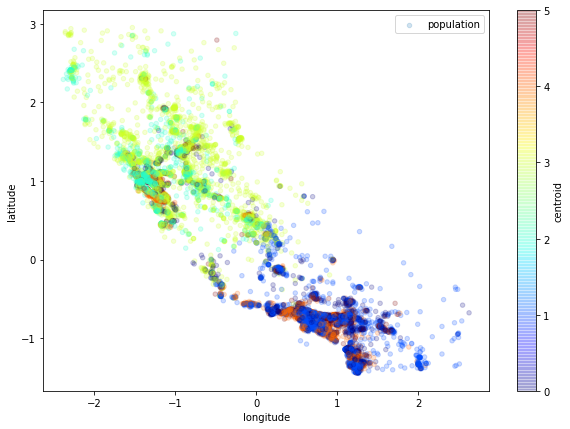

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_1_6[1], values_1_6[2])
sse = get_sse(housing_prepared, values_1_6[1])
housing_df['centroid'] = values_1_6[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_1_6[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_1_7 = k_means(housing_prepared, 7, 1, 3)

[array([3.07540113e+04, 3.74681739e+04, 2.47087382e+04, 1.67019987e+04,
       1.68576462e+04, 1.70364092e+04, 1.69494743e+04, 1.70764006e+04,
       5.07274753e+03, 5.24313774e+03, 2.00000000e+00, 1.64115415e+03,
       1.91737597e+03]), array([1.85472908e+04, 1.78415040e+04, 4.64297392e+04, 5.76681919e+05,
       5.32384935e+05, 5.19437504e+05, 5.45486738e+05, 1.84512952e+04,
       4.07085003e+03, 3.67886226e+03, 2.00000000e+00, 1.67412000e+03,
       1.87428099e+03]), array([2.49985427e+04, 2.61812540e+04, 2.64446636e+04, 2.05680211e+04,
       1.99278138e+04, 1.85984636e+04, 1.97512734e+04, 1.79827039e+04,
       5.28529449e+03, 3.97872790e+03, 2.00213427e+00, 1.84700000e+03,
       1.85128339e+03]), array([1.70234691e+04, 1.69857120e+04, 2.71058663e+04, 6.10228124e+04,
       6.91486712e+04, 6.03927073e+04, 6.85600641e+04, 1.65847718e+04,
       4.09782215e+03, 3.58889644e+03, 2.00000000e+00, 1.65869347e+03,
       1.85887598e+03]), array([2.91069645e+04, 2.84317281e+04, 2.248261

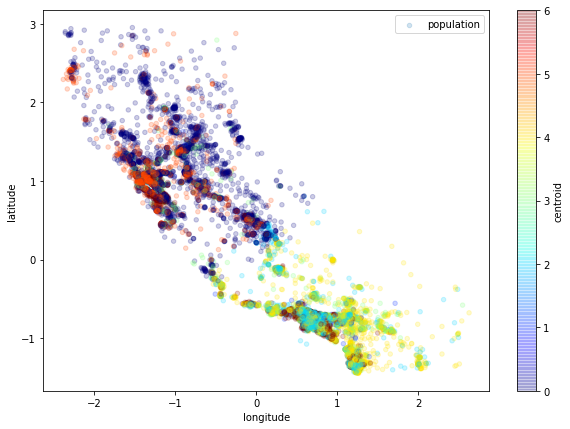

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_1_7[1], values_1_7[2])
sse = get_sse(housing_prepared, values_1_7[1])
housing_df['centroid'] = values_1_7[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_1_7[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_1_8 = k_means(housing_prepared, 8, 1, 3)

[array([3.69330490e+04, 3.46165072e+04, 2.33134610e+04, 2.15747714e+04,
       2.03905950e+04, 1.98120170e+04, 2.09645964e+04, 1.71567492e+04,
       4.30116805e+03, 3.63435638e+03, 2.00000000e+00, 1.74645037e+03,
       1.85504203e+03]), array([1.81360291e+04, 1.76328349e+04, 4.79332286e+04, 6.07804483e+05,
       5.58778926e+05, 5.44088904e+05, 5.73333261e+05, 1.87357453e+04,
       4.08463668e+03, 3.62238588e+03, 2.00000000e+00, 1.66676804e+03,
       1.87354658e+03]), array([2.00763702e+04, 1.95153270e+04, 2.84424186e+04, 7.57432391e+04,
       8.74272669e+04, 7.56580246e+04, 8.53219797e+04, 1.65578761e+04,
       4.15629718e+03, 3.59065165e+03, 2.00000000e+00, 1.71100029e+03,
       1.86072934e+03]), array([1.77375976e+04, 1.94550985e+04, 1.67691190e+04, 1.65175644e+04,
       1.90937572e+04, 1.85730100e+04, 1.87548341e+04, 1.02099745e+05,
       4.97760011e+03, 4.36525052e+03, 2.00000000e+00, 1.66753910e+03,
       1.85990518e+03]), array([2.64128547e+04, 3.70840158e+04, 2.343147

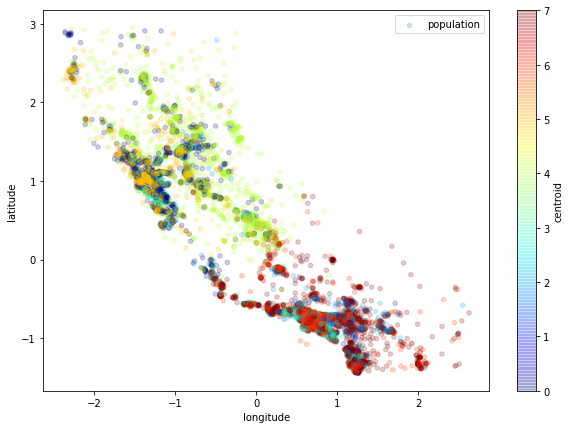

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_1_8[1], values_1_8[2])
sse = get_sse(housing_prepared, values_1_8[1])
housing_df['centroid'] = values_1_8[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_1_8[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_1_9 = k_means(housing_prepared, 9, 1, 3)

[array([2.49077330e+04, 2.63119090e+04, 2.75851886e+04, 2.02982493e+04,
       1.96119196e+04, 1.83226988e+04, 1.94319203e+04, 1.80141153e+04,
       5.42387554e+03, 4.05010463e+03, 2.00241743e+00, 1.84700000e+03,
       1.85162856e+03]), array([2.95670970e+04, 2.85820291e+04, 2.31036308e+04, 1.68857070e+04,
       1.65986555e+04, 1.65825318e+04, 1.66315814e+04, 1.74913710e+04,
       4.10919508e+03, 3.59819521e+03, 2.00000000e+00, 1.84700000e+03,
       1.98722870e+03]), array([2.74161084e+04, 2.68748874e+04, 2.35427328e+04, 3.89473510e+04,
       4.93693747e+04, 4.56191892e+04, 4.83373728e+04, 1.66744141e+04,
       4.56532217e+03, 3.64962722e+03, 2.00000000e+00, 1.84700000e+03,
       1.85080123e+03]), array([1.80531311e+04, 1.73806882e+04, 4.24712605e+04, 3.72939899e+05,
       3.54926659e+05, 3.27036180e+05, 3.54631228e+05, 1.81724539e+04,
       4.08434838e+03, 3.81600123e+03, 2.00000000e+00, 1.67221576e+03,
       1.88346712e+03]), array([4.03963493e+04, 3.10060645e+04, 1.733892

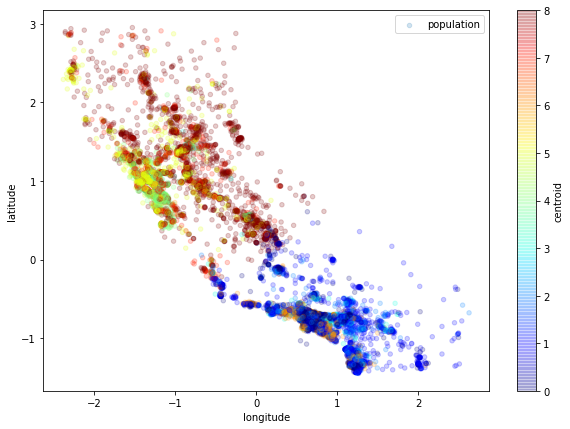

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_1_9[1], values_1_9[2])
sse = get_sse(housing_prepared, values_1_9[1])
housing_df['centroid'] = values_1_9[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_1_9[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_1_10 = k_means(housing_prepared, 10, 1, 3)

[array([2.71369755e+04, 2.71691711e+04, 1.83870089e+04, 2.01955831e+04,
       2.49247199e+04, 2.56717881e+04, 2.50093689e+04, 1.79391171e+04,
       4.55751792e+03, 3.71290229e+03, 2.00000000e+00, 1.84700000e+03,
       1.86369691e+03]), array([1.86232991e+04, 1.81964673e+04, 3.31337472e+04, 1.06929214e+05,
       1.13632082e+05, 9.67587113e+04, 1.10624157e+05, 1.70444489e+04,
       4.09209673e+03, 3.62494839e+03, 2.00000000e+00, 1.68655862e+03,
       1.86834295e+03]), array([4.07604400e+04, 3.54111867e+04, 3.98914559e+04, 1.92754267e+04,
       1.89129283e+04, 1.97394814e+04, 1.88825018e+04, 1.87864790e+04,
       5.86191256e+03, 3.60151667e+03, 2.00000000e+00, 3.83640320e+03,
       1.85104085e+03]), array([3.57714232e+04, 3.57207263e+04, 2.43842690e+04, 2.46008299e+04,
       2.49077604e+04, 2.29480628e+04, 2.55721054e+04, 1.65796025e+04,
       4.63629522e+03, 3.83920209e+03, 2.00000000e+00, 1.73429117e+03,
       1.85403081e+03]), array([2.56226033e+04, 3.78886999e+04, 2.315374

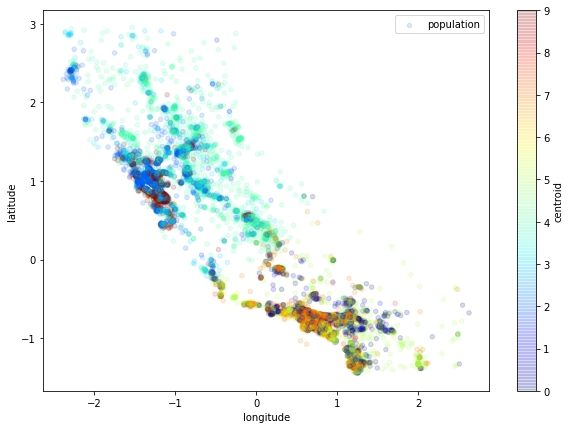

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_1_10[1], values_1_10[2])
sse = get_sse(housing_prepared, values_1_10[1])
housing_df['centroid'] = values_1_10[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_1_10[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.15, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

The following 18 cells will run the manhattan distance. A number of interesting patterns occur, primarily the distinctiveness of the coastal cities. As the k value rises, the clusters appear as distinct quadrants, which in contrast to the minkowski trials, is quite interesting. Perhaps this is due to the simplification of the distance calculation, but it highlights the north/south/east/west price variance well.

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_2_2 = k_means(housing_prepared, 2, 2, 0)

[array([3.36080780e+04, 3.46178845e+04, 1.65204073e+04, 1.65825078e+04,
       1.66926565e+04, 1.68502765e+04, 1.66926278e+04, 1.65690888e+04,
       5.24590315e+03, 4.00141936e+03, 2.00000000e+00, 1.97741695e+03,
       1.87052404e+03]), array([2.69923680e+04, 2.76114073e+04, 1.65171539e+04, 1.65552232e+04,
       1.66227474e+04, 1.67193728e+04, 1.66227298e+04, 1.65469970e+04,
       4.79079774e+03, 3.84046328e+03, 1.99990626e+00, 1.84700000e+03,
       1.86288441e+03])]
[array([0.50515198, 0.4869945 , 1.05408817, 0.88449583, 0.86753165,
       0.85626292, 0.89495086, 0.98217313, 0.37896858, 0.49945983,
       0.        , 0.4356954 , 0.29190451]), array([0.37119025, 0.25774051, 0.95516523, 1.07904706, 1.08551333,
       1.08633863, 1.06795034, 1.01126001, 0.47704561, 0.39578809,
       0.01469397, 0.        , 0.36261984])]
[array([-1.01753277,  1.04715274,  0.02256464, -0.06534594, -0.10459887,
       -0.14313177, -0.10459055, -0.05879978,  0.17376914,  0.47745139,
        0.        ,

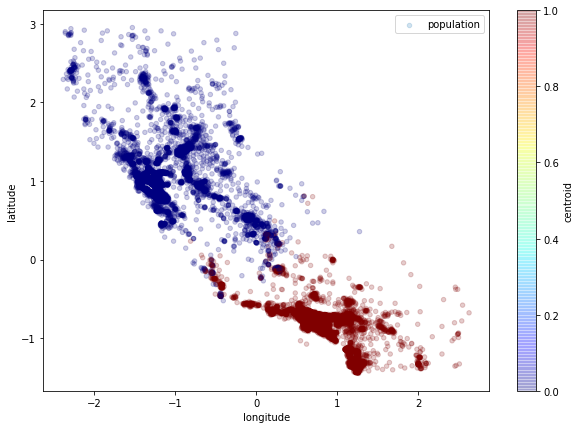

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_2_2[1], values_2_2[2])
sse = get_sse(housing_prepared, values_2_2[1])
housing_df['centroid'] = values_2_2[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_2_2[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_2_3 = k_means(housing_prepared, 3, 2, 0)

[array([3.43021435e+04, 3.54631882e+04, 1.65855861e+04, 1.71309042e+04,
       1.73891176e+04, 1.76726127e+04, 1.74241758e+04, 1.65724926e+04,
       5.27279353e+03, 3.97540092e+03, 2.00000000e+00, 2.01272590e+03,
       1.86964283e+03]), array([1.74135522e+04, 1.71556750e+04, 3.38445308e+04, 1.28989996e+05,
       1.32041582e+05, 1.15164233e+05, 1.31463450e+05, 1.71522843e+04,
       4.07644439e+03, 3.63274233e+03, 2.00000000e+00, 1.67333292e+03,
       1.86440374e+03]), array([2.66365824e+04, 2.74509964e+04, 1.66231979e+04, 1.71118175e+04,
       1.69686522e+04, 1.67220893e+04, 1.69445686e+04, 1.65197166e+04,
       4.79087629e+03, 3.85383395e+03, 1.99996061e+00, 1.84700000e+03,
       1.86590361e+03])]
[array([0.48880618, 0.46600056, 1.04626824, 0.55219209, 0.56769818,
       0.56929183, 0.58606028, 0.9858207 , 0.37633891, 0.49920499,
       0.        , 0.43972246, 0.29298672]), array([0.96014476, 0.90077457, 0.68292347, 1.79852355, 1.60841987,
       1.82428908, 1.59532233, 0.92821

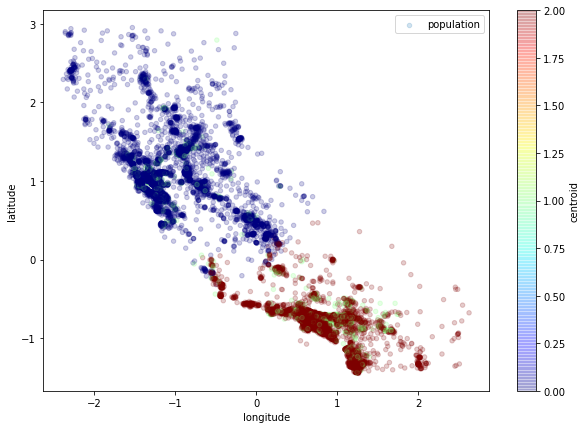

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_2_3[1], values_2_3[2])
sse = get_sse(housing_prepared, values_2_3[1])
housing_df['centroid'] = values_2_3[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_2_3[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_2_4 = k_means(housing_prepared, 4, 2, 0)

[array([1.84085272e+04, 1.75121021e+04, 4.43376660e+04, 3.92245440e+05,
       3.81342717e+05, 3.49865229e+05, 3.79606570e+05, 1.74203854e+04,
       4.10106111e+03, 3.88714003e+03, 2.00000000e+00, 1.66806836e+03,
       1.89309129e+03]), array([3.44978883e+04, 3.58360799e+04, 1.67762522e+04, 1.77725783e+04,
       1.81800536e+04, 1.84994615e+04, 1.82686738e+04, 1.65874117e+04,
       5.33518080e+03, 3.98569440e+03, 2.00000000e+00, 2.04485811e+03,
       1.87129599e+03]), array([2.66029592e+04, 2.74873282e+04, 1.68923995e+04, 1.78875196e+04,
       1.77906588e+04, 1.72522072e+04, 1.77296743e+04, 1.65205278e+04,
       4.82159235e+03, 3.87644207e+03, 2.00004816e+00, 1.84700000e+03,
       1.86674979e+03]), array([1.68390999e+04, 1.68415616e+04, 2.66469514e+04, 4.37714413e+04,
       4.79909679e+04, 4.20643938e+04, 4.80461476e+04, 1.66348362e+04,
       4.08736084e+03, 3.58923636e+03, 2.00000000e+00, 1.67075290e+03,
       1.85114036e+03])]
[array([0.9439348 , 0.895124  , 0.61415373, 2.2

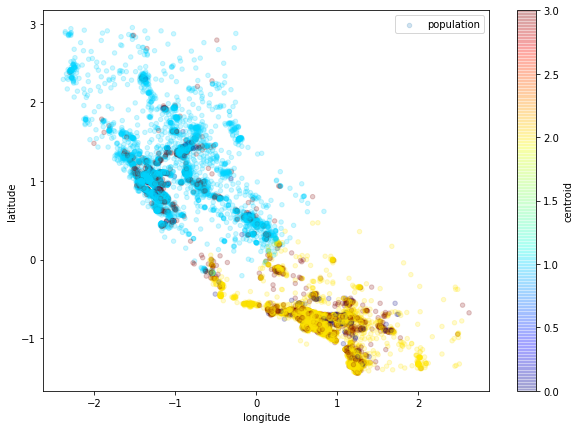

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_2_4[1], values_2_4[2])
sse = get_sse(housing_prepared, values_2_4[1])
housing_df['centroid'] = values_2_4[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_2_4[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_2_5 = k_means(housing_prepared, 5, 2, 0)

[array([4.60745286e+04, 3.22421156e+04, 2.17103025e+04, 1.71202410e+04,
       1.74622720e+04, 1.78021272e+04, 1.73048494e+04, 1.85467992e+04,
       4.43673150e+03, 5.24601087e+03, 2.00000000e+00, 4.75655893e+03,
       1.86756798e+03]), array([1.86731697e+04, 1.75810459e+04, 4.55802579e+04, 4.58288337e+05,
       4.39034859e+05, 4.08213868e+05, 4.36777122e+05, 1.75188216e+04,
       4.09831025e+03, 3.89721976e+03, 2.00000000e+00, 1.66908680e+03,
       1.89906002e+03]), array([2.71026542e+04, 2.81926983e+04, 1.69061216e+04, 1.77743968e+04,
       1.76806983e+04, 1.71624826e+04, 1.76084090e+04, 1.65538512e+04,
       4.99497471e+03, 3.99734990e+03, 2.00007906e+00, 1.84700000e+03,
       1.86871002e+03]), array([2.42990768e+04, 3.52957797e+04, 1.80396238e+04, 1.78790260e+04,
       1.81403237e+04, 1.83991769e+04, 1.85080410e+04, 2.00940881e+04,
       6.60833303e+03, 9.19387480e+03, 2.00000000e+00, 1.80816365e+03,
       1.98390069e+03]), array([1.75379606e+04, 1.75626531e+04, 2.765425

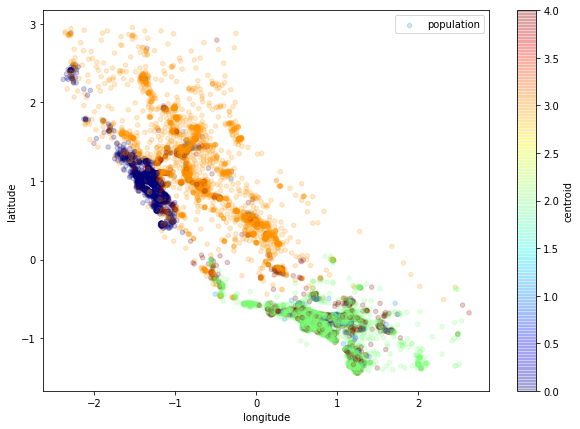

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_2_5[1], values_2_5[2])
sse = get_sse(housing_prepared, values_2_5[1])
housing_df['centroid'] = values_2_5[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_2_5[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_2_6 = k_means(housing_prepared, 6, 2, 0)

[array([1.90130932e+04, 1.79265495e+04, 4.45777600e+04, 3.88499605e+05,
       3.70424030e+05, 3.44427105e+05, 3.69088145e+05, 1.75664198e+04,
       4.09997816e+03, 3.93231186e+03, 2.00000000e+00, 1.69309878e+03,
       1.88509941e+03]), array([3.75760852e+04, 3.41000912e+04, 2.39287041e+04, 3.51088084e+04,
       3.48652922e+04, 3.07960419e+04, 3.68396856e+04, 1.69906684e+04,
       4.36346989e+03, 3.60096221e+03, 2.00000000e+00, 1.88462758e+03,
       1.85659470e+03]), array([2.77831784e+04, 2.74890371e+04, 2.27644030e+04, 3.10015456e+04,
       3.57776271e+04, 3.33405485e+04, 3.52865202e+04, 1.65457836e+04,
       4.55879075e+03, 3.68775015e+03, 2.00000000e+00, 1.84700000e+03,
       1.85649238e+03]), array([2.69859335e+04, 2.81355900e+04, 1.73020414e+04, 1.86793847e+04,
       1.86910458e+04, 1.79206456e+04, 1.85928126e+04, 1.65574875e+04,
       5.00625295e+03, 4.00258924e+03, 2.00024068e+00, 1.84700000e+03,
       1.86820374e+03]), array([4.64297333e+04, 3.25738218e+04, 2.433838

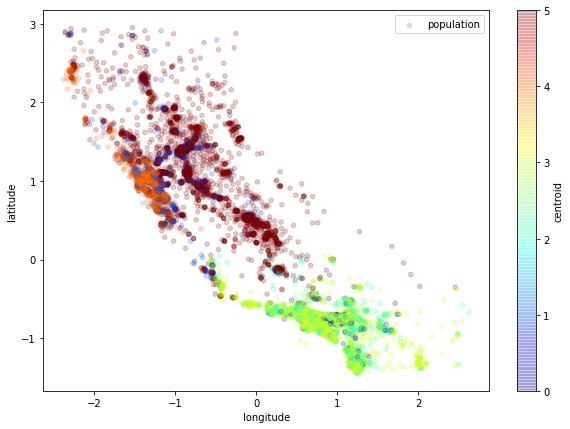

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_2_6[1], values_2_6[2])
sse = get_sse(housing_prepared, values_2_6[1])
housing_df['centroid'] = values_2_6[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_2_6[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_2_7 = k_means(housing_prepared, 7, 2, 0)

[array([2.38918442e+04, 3.49934762e+04, 1.74689909e+04, 1.89024446e+04,
       1.92660877e+04, 1.95797159e+04, 1.98385571e+04, 2.03141003e+04,
       6.64253050e+03, 9.32187748e+03, 2.00000000e+00, 1.81261266e+03,
       1.99188415e+03]), array([1.80047314e+04, 1.76268738e+04, 4.82287628e+04, 6.91280142e+05,
       6.33657268e+05, 6.08842562e+05, 6.54891009e+05, 1.89450321e+04,
       4.08195630e+03, 3.59846150e+03, 2.00000000e+00, 1.64924610e+03,
       1.86754214e+03]), array([4.64478743e+04, 3.25858886e+04, 2.49424352e+04, 1.86985702e+04,
       1.94723129e+04, 1.97649285e+04, 1.92904217e+04, 1.84356734e+04,
       4.59417071e+03, 5.22576468e+03, 2.00000000e+00, 5.16562473e+03,
       1.86710919e+03]), array([2.69268146e+04, 2.81222718e+04, 1.78476237e+04, 1.97244420e+04,
       1.98351219e+04, 1.88264532e+04, 1.97338460e+04, 1.65618218e+04,
       5.06950916e+03, 4.02109971e+03, 2.00051869e+00, 1.84700000e+03,
       1.86374129e+03]), array([3.83516054e+04, 3.47983566e+04, 2.131554

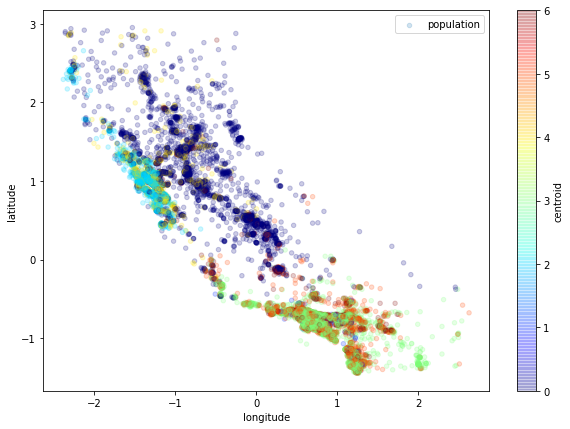

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_2_7[1], values_2_7[2])
sse = get_sse(housing_prepared, values_2_7[1])
housing_df['centroid'] = values_2_7[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_2_7[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_2_8 = k_means(housing_prepared, 8, 2, 0)

[array([3.37049644e+04, 3.03958538e+04, 1.70453379e+04, 1.71181108e+04,
       1.69974177e+04, 1.70716207e+04, 1.72179455e+04, 1.72525415e+04,
       7.27600000e+03, 4.20844207e+03, 2.00103458e+00, 1.84700000e+03,
       3.96694349e+03]), array([2.45565327e+04, 2.69989395e+04, 1.76142245e+04, 1.76327084e+04,
       1.74885494e+04, 1.68975767e+04, 1.73188668e+04, 1.69011435e+04,
       8.67684842e+03, 5.11402290e+03, 1.99981701e+00, 1.84700000e+03,
       2.05850128e+03]), array([3.02926565e+04, 3.04029763e+04, 2.30395871e+04, 2.83624543e+04,
       2.91039049e+04, 2.58084402e+04, 3.03917598e+04, 1.65574200e+04,
       5.11642074e+03, 4.05873685e+03, 2.00000000e+00, 1.77370398e+03,
       1.85165377e+03]), array([4.26833900e+04, 3.14657497e+04, 2.11647873e+04, 1.65182715e+04,
       1.72116017e+04, 1.69045717e+04, 1.69871982e+04, 3.03093859e+04,
       4.67961526e+03, 4.50697212e+03, 2.00000000e+00, 1.68088945e+03,
       1.85125170e+03]), array([4.74907554e+04, 3.34456881e+04, 3.586892

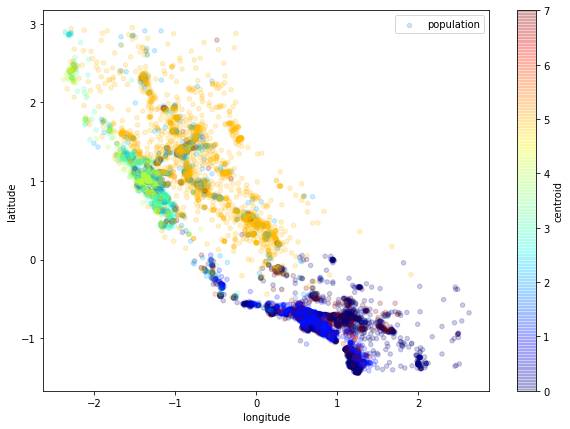

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_2_8[1], values_2_8[2])
sse = get_sse(housing_prepared, values_2_8[1])
housing_df['centroid'] = values_2_8[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_2_8[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_2_9 = k_means(housing_prepared, 9, 2, 0)

[array([1.74541582e+04, 1.71946552e+04, 5.05545796e+04, 7.61437819e+05,
       6.83250900e+05, 6.55765191e+05, 7.04298647e+05, 1.95771797e+04,
       4.07477509e+03, 3.59066180e+03, 2.00000000e+00, 1.64598856e+03,
       1.85526876e+03]), array([3.37421968e+04, 3.03201296e+04, 1.67103376e+04, 1.80498260e+04,
       1.79532365e+04, 1.80092081e+04, 1.83088443e+04, 1.73167515e+04,
       7.27600000e+03, 4.23815156e+03, 2.00154417e+00, 1.84700000e+03,
       3.91257688e+03]), array([2.28698302e+04, 2.13430623e+04, 3.52463761e+04, 1.51077655e+05,
       1.62210291e+05, 1.38702358e+05, 1.56671422e+05, 1.69979212e+04,
       4.12800000e+03, 3.68960700e+03, 2.00000000e+00, 1.79147891e+03,
       1.88129218e+03]), array([2.72891134e+04, 2.74054287e+04, 2.16162335e+04, 2.62337378e+04,
       3.00776862e+04, 2.93943245e+04, 3.05435166e+04, 1.65550240e+04,
       4.76580506e+03, 3.77129534e+03, 2.00000000e+00, 1.84700000e+03,
       1.85346932e+03]), array([3.58345447e+04, 3.40146189e+04, 2.724877

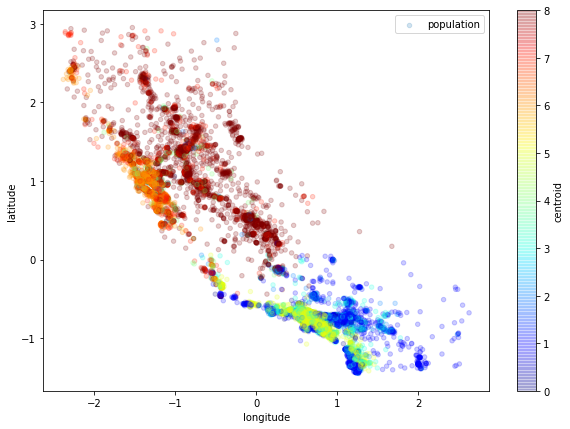

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_2_9[1], values_2_9[2])
sse = get_sse(housing_prepared, values_2_9[1])
housing_df['centroid'] = values_2_9[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_2_9[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_2_10 = k_means(housing_prepared, 10, 2, 0)

[array([2.44274925e+04, 2.68775359e+04, 1.85857337e+04, 1.88202330e+04,
       1.88523009e+04, 1.78019984e+04, 1.86284671e+04, 1.69202824e+04,
       8.60316661e+03, 5.08301371e+03, 1.99988624e+00, 1.84700000e+03,
       2.05440768e+03]), array([2.32035044e+04, 3.45093356e+04, 2.14760572e+04, 1.66260038e+04,
       1.65979694e+04, 1.65233067e+04, 1.65382379e+04, 1.96943247e+04,
       6.96945420e+03, 9.58213431e+03, 2.00000000e+00, 1.79369767e+03,
       1.97606455e+03]), array([2.29560124e+04, 2.13974320e+04, 3.52706637e+04, 1.51251634e+05,
       1.62158968e+05, 1.38832371e+05, 1.56575587e+05, 1.70052037e+04,
       4.12574844e+03, 3.69204364e+03, 2.00000000e+00, 1.79136017e+03,
       1.88101074e+03]), array([4.72935051e+04, 3.39023274e+04, 3.57340379e+04, 1.86275643e+04,
       1.87552260e+04, 1.95320168e+04, 1.86351215e+04, 1.66650192e+04,
       5.94294099e+03, 5.06688096e+03, 2.00000000e+00, 7.56376398e+03,
       1.87401899e+03]), array([2.74378534e+04, 2.76774373e+04, 2.158755

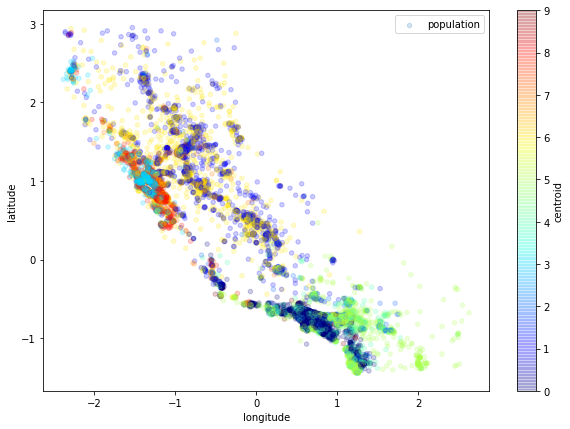

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_2_10[1], values_2_10[2])
sse = get_sse(housing_prepared, values_2_10[1])
housing_df['centroid'] = values_2_10[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_2_10[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

The following 18 cells will run the euclidean distance. There once again was a deep connection visually to the coastal cities in a more blended cluster than the manhattan, but not as blended as the sup calculation.

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_3_2 = k_means(housing_prepared, 2, 3, 0)

[array([1.73349095e+04, 1.72189946e+04, 2.89214550e+04, 7.43447006e+04,
       7.96703371e+04, 7.00710072e+04, 7.93687341e+04, 1.67873364e+04,
       4.09520076e+03, 3.58854202e+03, 2.00000000e+00, 1.66692093e+03,
       1.85340600e+03]), array([1.65282419e+04, 1.65259541e+04, 1.67569275e+04, 1.76534535e+04,
       1.77585665e+04, 1.75691029e+04, 1.77526137e+04, 1.65174344e+04,
       4.07033686e+03, 3.58554288e+03, 1.99976253e+00, 1.64092168e+03,
       1.85083377e+03])]
[array([0.97009626, 0.91706521, 0.73041974, 1.60696032, 1.45387226,
       1.59264214, 1.43933603, 0.94450258, 0.4999523 , 0.47099808,
       0.        , 0.25811796, 0.3202476 ]), array([1.00007663, 1.00768629, 0.97215228, 0.46540852, 0.48040194,
       0.51429203, 0.48951218, 1.00616552, 0.49582315, 0.46523132,
       0.01175251, 0.32200012, 0.33674646])]
[array([ 0.22324215, -0.20692273, -0.86691499,  1.87148735,  1.95575975,
        1.80101122,  1.95108444,  0.12913144,  0.47984267,  0.33235005,
        0.        ,

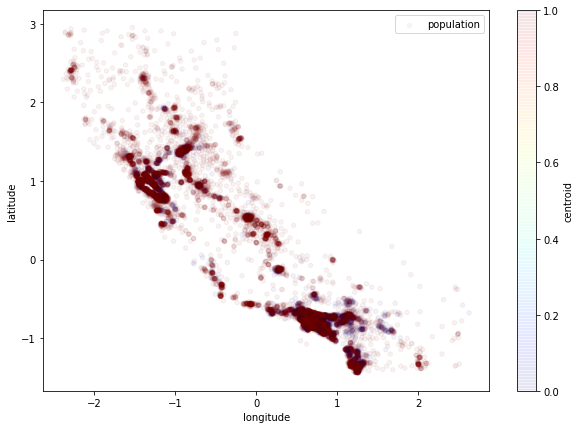

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_3_2[1], values_3_2[2])
sse = get_sse(housing_prepared, values_3_2[1])
housing_df['centroid'] = values_3_2[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_3_2[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.05, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_3_3 = k_means(housing_prepared, 3, 3, 0)

[array([3.45075702e+04, 3.55466537e+04, 1.66105069e+04, 1.72414615e+04,
       1.75255458e+04, 1.78314390e+04, 1.75682152e+04, 1.65738643e+04,
       5.25109237e+03, 3.95251498e+03, 2.00000000e+00, 2.01499283e+03,
       1.86781879e+03]), array([1.74787092e+04, 1.72747558e+04, 3.12630599e+04, 1.03576520e+05,
       1.08761620e+05, 9.52136304e+04, 1.08255860e+05, 1.70093030e+04,
       4.08916189e+03, 3.60220191e+03, 2.00000000e+00, 1.66859982e+03,
       1.86076093e+03]), array([2.66316237e+04, 2.73697411e+04, 1.66759072e+04, 1.73424564e+04,
       1.72131143e+04, 1.68728682e+04, 1.71783333e+04, 1.65178511e+04,
       4.76573718e+03, 3.83561986e+03, 1.99998063e+00, 1.84700000e+03,
       1.86518034e+03])]
[array([0.48120701, 0.46780551, 1.04727509, 0.52684191, 0.54110319,
       0.5407087 , 0.55864477, 0.98735211, 0.37846651, 0.498931  ,
       0.        , 0.43996896, 0.29529019]), array([0.95481763, 0.89533224, 0.71225568, 1.72863243, 1.54531655,
       1.7272553 , 1.52843152, 0.95219

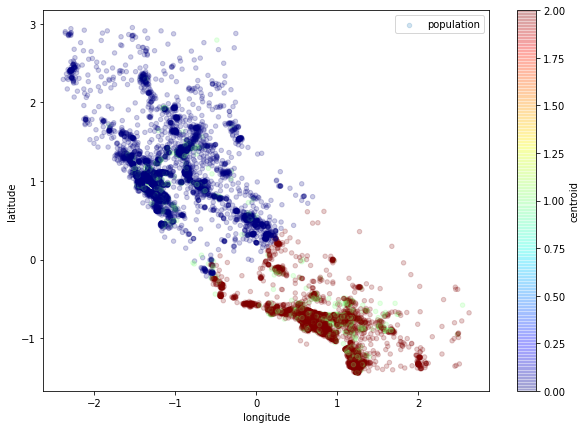

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_3_3[1], values_3_3[2])
sse = get_sse(housing_prepared, values_3_3[1])
housing_df['centroid'] = values_3_3[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_3_3[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_3_4 = k_means(housing_prepared, 4, 3, 0)

[array([2.65805926e+04, 2.69556172e+04, 1.76520517e+04, 1.81219214e+04,
       1.72281910e+04, 1.68481281e+04, 1.72176194e+04, 1.88373798e+04,
       4.62690385e+03, 3.76335172e+03, 2.00028361e+00, 1.84700000e+03,
       1.86747084e+03]), array([3.48828742e+04, 3.62751117e+04, 1.66698680e+04, 1.73090022e+04,
       1.74836206e+04, 1.78615911e+04, 1.75411917e+04, 1.69280886e+04,
       5.35265552e+03, 3.99141523e+03, 2.00000000e+00, 2.04528983e+03,
       1.87047481e+03]), array([1.72666031e+04, 1.70596038e+04, 3.11946488e+04, 1.10340435e+05,
       1.17805580e+05, 1.02478085e+05, 1.17178584e+05, 1.67356242e+04,
       4.07999388e+03, 3.61347118e+03, 2.00000000e+00, 1.66262253e+03,
       1.86482726e+03]), array([2.16614453e+04, 2.34560406e+04, 2.10437688e+04, 1.69227967e+04,
       1.68959894e+04, 1.67078627e+04, 1.67987569e+04, 5.63398612e+04,
       4.99573365e+03, 4.03675774e+03, 2.00000000e+00, 1.78152490e+03,
       1.85812563e+03])]
[array([0.37861375, 0.29536805, 0.84652274, 0.4

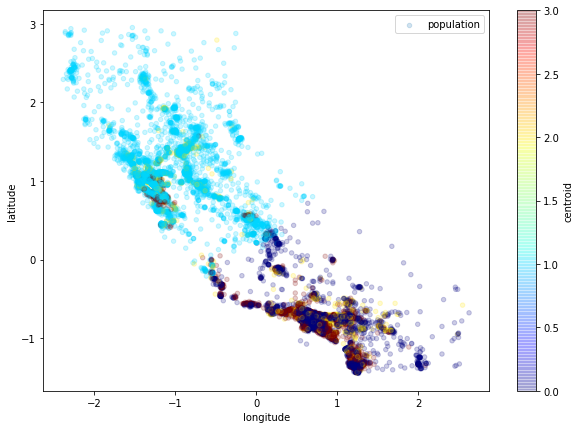

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_3_4[1], values_3_4[2])
sse = get_sse(housing_prepared, values_3_4[1])
housing_df['centroid'] = values_3_4[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_3_4[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_3_5 = k_means(housing_prepared, 5, 3, 0)

[array([2.80409479e+04, 2.77167625e+04, 2.19374594e+04, 2.35242645e+04,
       2.60530209e+04, 2.55796703e+04, 2.59114172e+04, 1.65761876e+04,
       4.50921324e+03, 3.69483497e+03, 2.00000000e+00, 1.84700000e+03,
       1.86587571e+03]), array([1.82747263e+04, 1.76416940e+04, 3.85498510e+04, 2.65038642e+05,
       2.60796945e+05, 2.34506235e+05, 2.58647272e+05, 1.76352374e+04,
       4.07016843e+03, 3.69901018e+03, 2.00000000e+00, 1.67169341e+03,
       1.88238350e+03]), array([3.30820375e+04, 3.37218251e+04, 2.51070052e+04, 2.10631571e+04,
       2.01244662e+04, 1.92583201e+04, 2.04769550e+04, 1.69016925e+04,
       4.57660655e+03, 3.98202189e+03, 2.00000000e+00, 1.69296189e+03,
       1.87227684e+03]), array([3.52103715e+04, 3.60885999e+04, 1.93411117e+04, 1.99799119e+04,
       2.04189000e+04, 2.09608424e+04, 2.06692726e+04, 1.68930595e+04,
       5.60065907e+03, 3.90941937e+03, 2.00000000e+00, 2.26655172e+03,
       1.86583646e+03]), array([2.62884003e+04, 2.71923902e+04, 1.794573

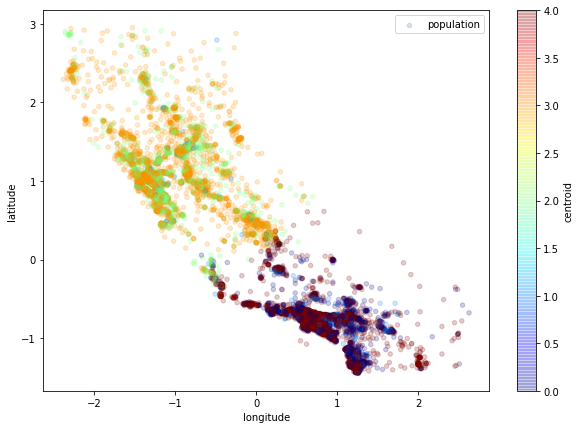

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_3_5[1], values_3_5[2])
sse = get_sse(housing_prepared, values_3_5[1])
housing_df['centroid'] = values_3_5[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_3_5[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_3_6 = k_means(housing_prepared, 6, 3, 0)

[array([1.83986382e+04, 1.77832361e+04, 4.72949348e+04, 5.93531868e+05,
       5.47994843e+05, 5.26946870e+05, 5.60394901e+05, 1.86576693e+04,
       4.07228622e+03, 3.65505245e+03, 2.00000000e+00, 1.67047004e+03,
       1.87020150e+03]), array([1.68322266e+04, 1.80969964e+04, 1.75354042e+04, 1.65120001e+04,
       1.89421006e+04, 1.83180120e+04, 1.86272344e+04, 1.05051489e+05,
       4.82952071e+03, 4.34315893e+03, 2.00000000e+00, 1.65251080e+03,
       1.86274963e+03]), array([2.61111232e+04, 2.69654106e+04, 2.09153880e+04, 2.08789828e+04,
       2.04339417e+04, 1.91845268e+04, 2.03239492e+04, 1.75655699e+04,
       4.93556841e+03, 3.88168475e+03, 2.00116412e+00, 1.84700000e+03,
       1.85529059e+03]), array([2.69632241e+04, 2.64565030e+04, 2.13791233e+04, 1.75849130e+04,
       1.88021880e+04, 1.89919225e+04, 1.87695050e+04, 1.70180121e+04,
       4.24935445e+03, 3.61601344e+03, 2.00000000e+00, 1.84700000e+03,
       1.89324356e+03]), array([1.65459877e+04, 1.65476612e+04, 2.935470

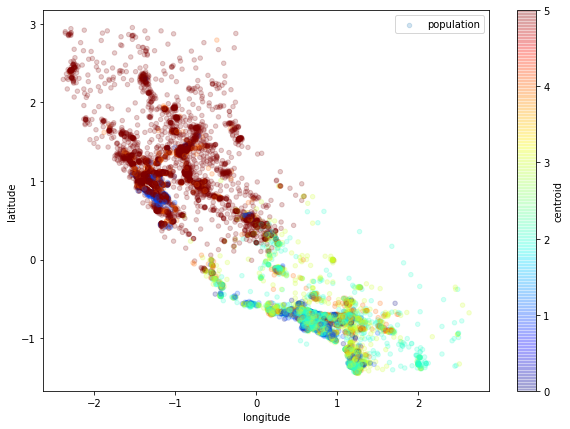

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_3_6[1], values_3_6[2])
sse = get_sse(housing_prepared, values_3_6[1])
housing_df['centroid'] = values_3_6[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_3_6[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_3_7 = k_means(housing_prepared, 7, 3, 0)

[array([3.05255336e+04, 3.69352449e+04, 2.49871444e+04, 1.65709467e+04,
       1.66917954e+04, 1.68214219e+04, 1.67542007e+04, 1.68782798e+04,
       5.02287448e+03, 5.23048243e+03, 2.00000000e+00, 1.64197816e+03,
       1.92159000e+03]), array([3.98380271e+04, 3.47991832e+04, 3.46644078e+04, 1.95662054e+04,
       1.95911813e+04, 2.02636453e+04, 1.95704973e+04, 1.72581598e+04,
       5.77754358e+03, 3.59384677e+03, 2.00000000e+00, 3.64194219e+03,
       1.85103855e+03]), array([1.65533814e+04, 1.65489459e+04, 2.95533822e+04, 8.05227477e+04,
       8.59371263e+04, 7.25997620e+04, 8.54459425e+04, 1.70031155e+04,
       4.07066205e+03, 3.60288956e+03, 2.00000000e+00, 1.64384577e+03,
       1.86107701e+03]), array([2.79675718e+04, 2.76467937e+04, 2.06020991e+04, 1.79165195e+04,
       1.96265779e+04, 1.97724545e+04, 1.95851344e+04, 1.70918374e+04,
       4.35181042e+03, 3.66410084e+03, 2.00000000e+00, 1.84700000e+03,
       1.89256302e+03]), array([2.60703977e+04, 2.68115610e+04, 2.063902

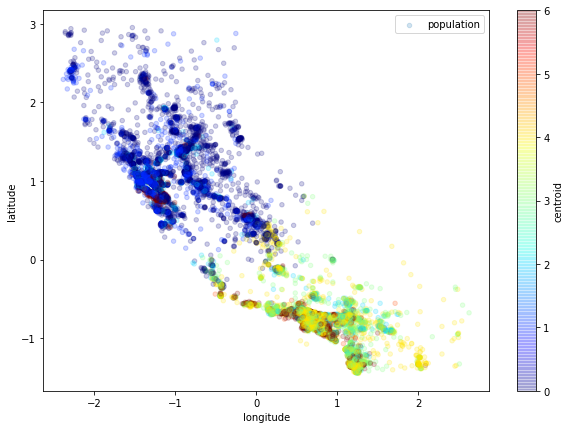

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_3_7[1], values_3_7[2])
sse = get_sse(housing_prepared, values_3_7[1])
housing_df['centroid'] = values_3_7[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_3_7[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_3_8 = k_means(housing_prepared, 8, 3, 0)

[array([1.90121716e+04, 2.10626839e+04, 1.77254126e+04, 1.65882286e+04,
       1.93869211e+04, 1.87554254e+04, 1.90914032e+04, 9.26089540e+04,
       5.10817076e+03, 4.30616192e+03, 2.00000000e+00, 1.71798505e+03,
       1.86265813e+03]), array([4.20156085e+04, 3.46255884e+04, 3.84123837e+04, 1.92932323e+04,
       1.93697000e+04, 2.00434241e+04, 1.92855936e+04, 1.68878204e+04,
       5.62955583e+03, 3.74468449e+03, 2.00000000e+00, 4.25767040e+03,
       1.85171725e+03]), array([1.82854630e+04, 1.77117883e+04, 4.70646697e+04, 6.28835218e+05,
       5.80306222e+05, 5.66761391e+05, 5.98221227e+05, 1.86447465e+04,
       4.07500000e+03, 3.62564352e+03, 2.00000000e+00, 1.66117130e+03,
       1.86707407e+03]), array([3.70469735e+04, 3.47471721e+04, 2.21257948e+04, 2.36180503e+04,
       2.28460736e+04, 2.13839967e+04, 2.36190820e+04, 1.67866937e+04,
       4.40720354e+03, 3.63483693e+03, 2.00000000e+00, 1.80965957e+03,
       1.85351172e+03]), array([2.82168932e+04, 2.78048288e+04, 2.068825

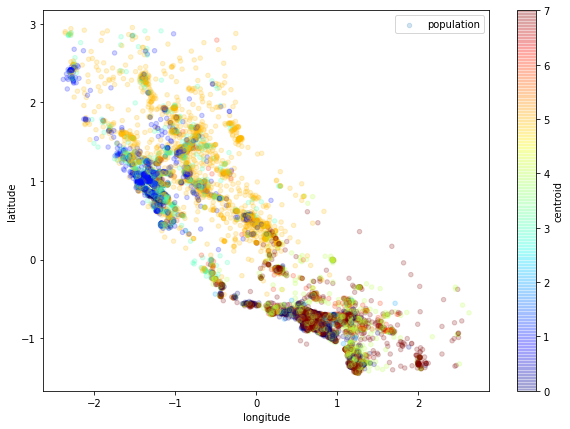

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_3_8[1], values_3_8[2])
sse = get_sse(housing_prepared, values_3_8[1])
housing_df['centroid'] = values_3_8[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_3_8[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_3_9 = k_means(housing_prepared, 9, 3, 0)

[array([2.71481532e+04, 2.72177537e+04, 1.88563017e+04, 2.10461110e+04,
       2.50233711e+04, 2.55257105e+04, 2.51382800e+04, 1.70836131e+04,
       4.62291007e+03, 3.73049495e+03, 2.00000000e+00, 1.84700000e+03,
       1.85927223e+03]), array([1.65290137e+04, 1.73452592e+04, 1.65232440e+04, 1.65123217e+04,
       1.92646357e+04, 1.87754707e+04, 1.89321575e+04, 1.38917729e+05,
       4.84350127e+03, 4.49817949e+03, 2.00000000e+00, 1.64090240e+03,
       1.86052685e+03]), array([3.67322319e+04, 3.46217585e+04, 2.23770397e+04, 2.36580240e+04,
       2.30491961e+04, 2.15337631e+04, 2.38391378e+04, 1.66741238e+04,
       4.41458888e+03, 3.64771245e+03, 2.00000000e+00, 1.80027132e+03,
       1.85458296e+03]), array([4.19631640e+04, 3.46504514e+04, 3.87117417e+04, 1.93492478e+04,
       1.93470184e+04, 2.00679561e+04, 1.92787908e+04, 1.70946073e+04,
       5.65809512e+03, 3.73622076e+03, 2.00000000e+00, 4.25750332e+03,
       1.85175897e+03]), array([3.09167895e+04, 2.97227453e+04, 2.771790

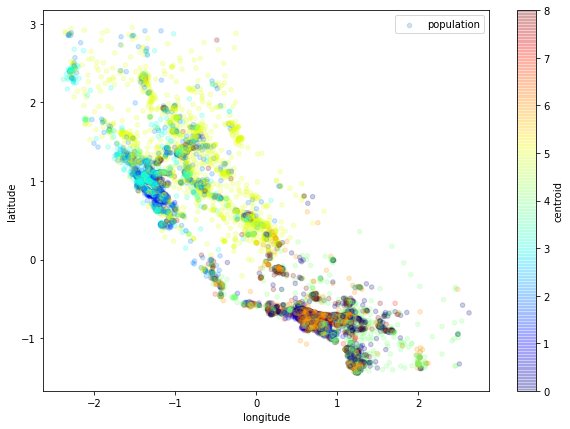

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_3_9[1], values_3_9[2])
sse = get_sse(housing_prepared, values_3_9[1])
housing_df['centroid'] = values_3_9[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_3_9[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_3_10 = k_means(housing_prepared, 10, 3, 0)

[array([1.82839480e+04, 1.77356803e+04, 4.79253928e+04, 6.46455621e+05,
       5.91925738e+05, 5.74247019e+05, 6.11421821e+05, 1.88496002e+04,
       4.07629812e+03, 3.61320444e+03, 2.00000000e+00, 1.65807738e+03,
       1.86364826e+03]), array([2.71689562e+04, 2.71897190e+04, 1.88262579e+04, 2.12118932e+04,
       2.61293635e+04, 2.66728469e+04, 2.62905564e+04, 1.74953589e+04,
       4.60203714e+03, 3.71923099e+03, 2.00000000e+00, 1.84700000e+03,
       1.85910348e+03]), array([4.09873592e+04, 3.04821055e+04, 1.72650487e+04, 1.68859395e+04,
       1.96191569e+04, 1.87042844e+04, 1.91197980e+04, 5.79815642e+04,
       4.07207583e+03, 4.16174517e+03, 2.00000000e+00, 2.25081519e+03,
       1.85143961e+03]), array([3.59726265e+04, 3.51354083e+04, 2.27290419e+04, 2.48848994e+04,
       2.52050875e+04, 2.28184687e+04, 2.59461622e+04, 1.65388924e+04,
       4.59136563e+03, 3.76553229e+03, 2.00000000e+00, 1.76531038e+03,
       1.85381686e+03]), array([1.81240588e+04, 1.77116231e+04, 3.340892

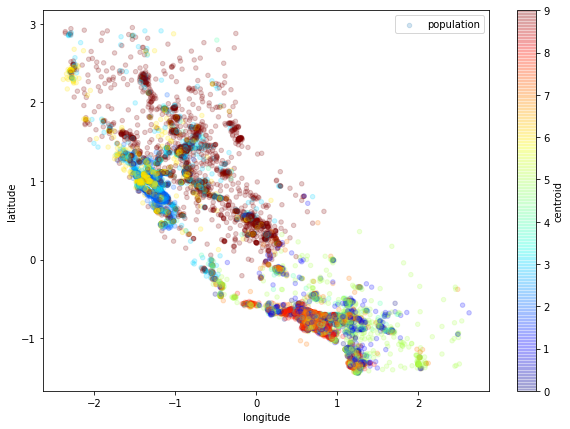

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_3_10[1], values_3_10[2])
sse = get_sse(housing_prepared, values_3_10[1])
housing_df['centroid'] = values_3_10[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_3_10[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

The following 18 cells are with the sup distance calculation. This calculation appeared to be nuanced, similar in representation to the minkowski, but also show a clear consistency in identifying the coast as roughly a cluster of high valued homes.

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_4_2 = k_means(housing_prepared, 2, 4, 0)

[array([1.99554255e+04, 2.04910961e+04, 2.44789511e+04, 1.89401617e+04,
       1.82548706e+04, 1.78300973e+04, 1.81945374e+04, 1.84922538e+04,
       4.18684168e+03, 3.71078005e+03, 2.00031954e+00, 1.64352813e+03,
       1.85528568e+03]), array([1.79968449e+04, 1.82278322e+04, 1.99474413e+04, 1.75590514e+04,
       1.72635459e+04, 1.70803788e+04, 1.72375296e+04, 1.73659083e+04,
       4.12029034e+03, 3.63951225e+03, 2.00000000e+00, 1.64174786e+03,
       1.85272403e+03])]
[array([0.81780138, 0.73037584, 0.76280008, 0.399072  , 0.45613429,
       0.46160912, 0.45959164, 0.63843824, 0.49934105, 0.42186235,
       0.01747808, 0.29743402, 0.35230935]), array([0.99523751, 1.0217922 , 0.86579655, 1.17981897, 1.18537243,
       1.19571041, 1.18617613, 1.12176215, 0.48674715, 0.48435017,
       0.        , 0.32600758, 0.3223556 ])]
[array([ 4.56662667e-01, -4.90899258e-01,  6.94618323e-01, -3.83476687e-01,
       -3.24887293e-01, -2.82536066e-01, -3.19214434e-01, -3.46306454e-01,
        5.248

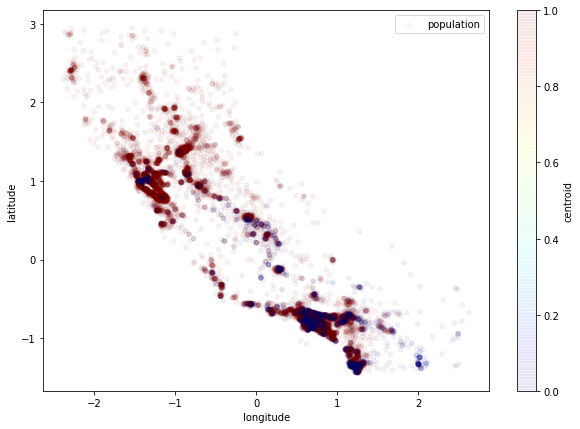

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_4_2[1], values_4_2[2])
sse = get_sse(housing_prepared, values_4_2[1])
housing_df['centroid'] = values_4_2[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_4_2[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.05, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_4_3 = k_means(housing_prepared, 3, 4, 0)

[array([3.18474556e+04, 3.18301706e+04, 1.67524675e+04, 1.71622058e+04,
       1.77112470e+04, 1.81351876e+04, 1.77415891e+04, 1.70401153e+04,
       4.80425056e+03, 3.71738242e+03, 2.00000000e+00, 1.99233519e+03,
       1.86057330e+03]), array([2.57615509e+04, 2.62236616e+04, 1.97906184e+04, 1.92900084e+04,
       1.86229585e+04, 1.78774630e+04, 1.85599002e+04, 1.78131735e+04,
       4.69125065e+03, 3.77519955e+03, 2.00051114e+00, 1.84700000e+03,
       1.86096955e+03]), array([2.06423680e+04, 2.01717146e+04, 2.96714955e+04, 3.20964517e+04,
       3.34338410e+04, 3.23736705e+04, 3.33512356e+04, 1.67719716e+04,
       4.13528328e+03, 3.58776679e+03, 2.00000000e+00, 1.74114733e+03,
       1.85098595e+03])]
[array([0.6353497 , 0.67526316, 1.0248293 , 0.56456246, 0.54434128,
       0.51679743, 0.56357682, 1.24425507, 0.42074597, 0.49145902,
       0.        , 0.43744027, 0.30562399]), array([0.38073282, 0.34363823, 0.72871844, 0.36223011, 0.41946073,
       0.45595583, 0.4240599 , 0.67254

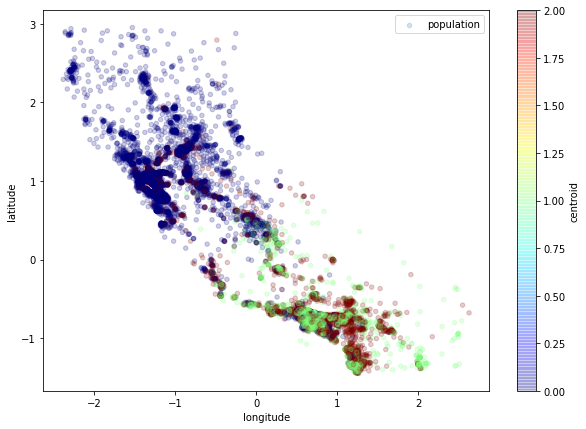

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_4_3[1], values_4_3[2])
sse = get_sse(housing_prepared, values_4_3[1])
housing_df['centroid'] = values_4_3[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_4_3[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_4_4 = k_means(housing_prepared, 4, 4, 0)

[array([2.02665668e+04, 2.08330535e+04, 2.44848852e+04, 2.63935549e+04,
       2.45405636e+04, 2.41331601e+04, 2.46276207e+04, 2.44972178e+04,
       4.33149249e+03, 3.68093056e+03, 2.00000000e+00, 1.71020355e+03,
       1.85464118e+03]), array([2.63145256e+04, 2.69031543e+04, 2.04404982e+04, 1.93197016e+04,
       1.83385778e+04, 1.76269509e+04, 1.82790306e+04, 1.85377202e+04,
       4.75784747e+03, 3.83009302e+03, 2.00072253e+00, 1.84566183e+03,
       1.86451660e+03]), array([3.07642977e+04, 3.75737878e+04, 2.43518460e+04, 1.66640196e+04,
       1.67114707e+04, 1.69267340e+04, 1.67904427e+04, 1.76060472e+04,
       5.12283306e+03, 5.18218105e+03, 2.00000000e+00, 1.64057544e+03,
       1.91341715e+03]), array([3.86147119e+04, 3.32031422e+04, 3.60512924e+04, 1.87605803e+04,
       1.89034155e+04, 1.96074962e+04, 1.88015775e+04, 1.69027337e+04,
       5.53209295e+03, 3.59642806e+03, 2.00000000e+00, 3.41867641e+03,
       1.85114945e+03])]
[array([0.82302844, 0.72053356, 0.80623077, 1.4

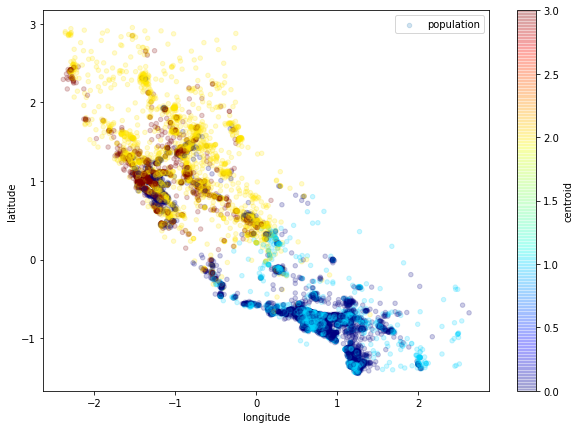

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_4_4[1], values_4_4[2])
sse = get_sse(housing_prepared, values_4_4[1])
housing_df['centroid'] = values_4_4[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_4_4[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_4_5 = k_means(housing_prepared, 5, 4, 0)

[array([3.70185446e+04, 3.91971031e+04, 1.92876317e+04, 1.81288059e+04,
       1.78410964e+04, 1.86464412e+04, 1.79942960e+04, 1.98041374e+04,
       5.69079546e+03, 3.98978545e+03, 2.00000000e+00, 2.21167574e+03,
       1.86470978e+03]), array([2.70839579e+04, 2.50411606e+04, 2.35030217e+04, 1.65218401e+04,
       1.66757922e+04, 1.67156776e+04, 1.66378302e+04, 1.80807471e+04,
       4.08521628e+03, 3.60284926e+03, 2.00000000e+00, 1.84317990e+03,
       1.88880923e+03]), array([1.69485845e+04, 1.67921570e+04, 3.16194647e+04, 1.23446999e+05,
       1.29341244e+05, 1.16946669e+05, 1.28609421e+05, 1.67520135e+04,
       4.07005043e+03, 3.63378214e+03, 2.00000000e+00, 1.65198691e+03,
       1.86672457e+03]), array([2.44979821e+04, 2.59300063e+04, 2.79015828e+04, 1.98928251e+04,
       1.91370708e+04, 1.80436650e+04, 1.89685632e+04, 1.83080410e+04,
       5.18357414e+03, 3.97951562e+03, 2.00232890e+00, 1.83572747e+03,
       1.85094428e+03]), array([1.82917213e+04, 1.72626354e+04, 1.969083

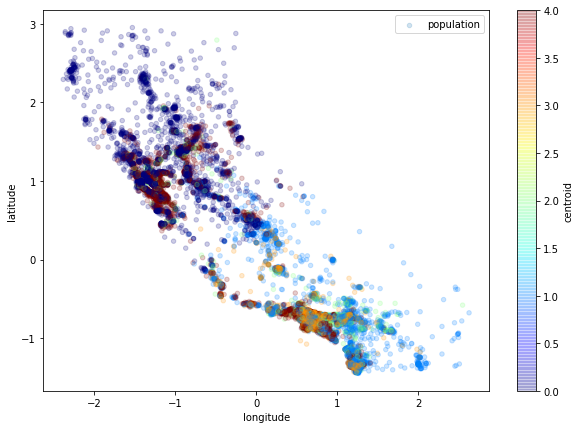

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_4_5[1], values_4_5[2])
sse = get_sse(housing_prepared, values_4_5[1])
housing_df['centroid'] = values_4_5[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_4_5[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_4_6 = k_means(housing_prepared, 6, 4, 0)

[array([1.69978038e+04, 1.68221629e+04, 3.18509552e+04, 1.29110670e+05,
       1.34189598e+05, 1.21170768e+05, 1.33156418e+05, 1.68343566e+04,
       4.07056063e+03, 3.63690887e+03, 2.00000000e+00, 1.65354940e+03,
       1.86996908e+03]), array([1.68416115e+04, 1.79636922e+04, 1.68744017e+04, 1.66203339e+04,
       1.78744824e+04, 1.74795163e+04, 1.76117319e+04, 7.76986002e+04,
       4.77958820e+03, 4.32243480e+03, 2.00000000e+00, 1.64064450e+03,
       1.85181738e+03]), array([2.88499656e+04, 2.76198742e+04, 2.29888773e+04, 1.65167400e+04,
       1.68602273e+04, 1.69032251e+04, 1.68109019e+04, 1.76036762e+04,
       4.17650757e+03, 3.59975815e+03, 2.00000000e+00, 1.84290576e+03,
       1.91001365e+03]), array([3.90706542e+04, 3.43296396e+04, 3.79040050e+04, 1.91199094e+04,
       1.88426814e+04, 1.96064654e+04, 1.88069505e+04, 1.84981470e+04,
       5.81377215e+03, 3.58551225e+03, 2.00000000e+00, 3.47715863e+03,
       1.85235430e+03]), array([2.45489363e+04, 2.58835845e+04, 2.690095

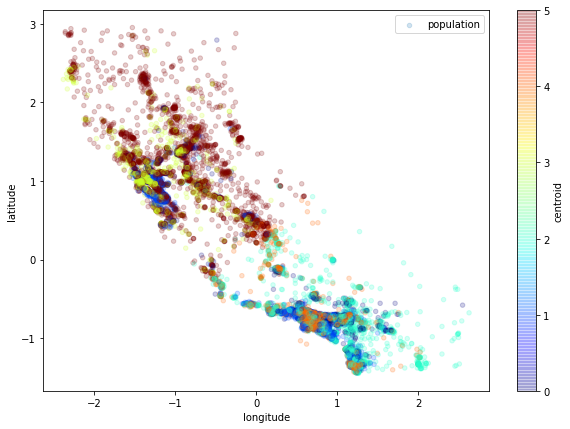

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_4_6[1], values_4_6[2])
sse = get_sse(housing_prepared, values_4_6[1])
housing_df['centroid'] = values_4_6[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_4_6[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_4_7 = k_means(housing_prepared, 7, 4, 0)

[array([3.90758127e+04, 3.43099053e+04, 3.81008141e+04, 1.91171143e+04,
       1.88416712e+04, 1.96035127e+04, 1.88015338e+04, 1.84954725e+04,
       5.80907805e+03, 3.58548565e+03, 2.00000000e+00, 3.49062522e+03,
       1.85260615e+03]), array([1.90418842e+04, 1.90344293e+04, 2.51553748e+04, 3.87534196e+04,
       4.75498193e+04, 4.55232717e+04, 4.72571440e+04, 1.66949586e+04,
       4.16372732e+03, 3.58819730e+03, 2.00000000e+00, 1.70444610e+03,
       1.85078253e+03]), array([2.44576261e+04, 2.57321139e+04, 2.79276201e+04, 1.98672888e+04,
       1.90576111e+04, 1.79620061e+04, 1.89050759e+04, 1.87563801e+04,
       5.15578989e+03, 3.93429238e+03, 2.00268067e+00, 1.84600040e+03,
       1.85078203e+03]), array([1.65866670e+04, 1.74060241e+04, 1.67901025e+04, 1.65642963e+04,
       1.80720471e+04, 1.75849253e+04, 1.77209950e+04, 7.75648811e+04,
       4.72780832e+03, 4.32115290e+03, 2.00000000e+00, 1.64083091e+03,
       1.85147093e+03]), array([1.84136781e+04, 1.75410695e+04, 4.268161

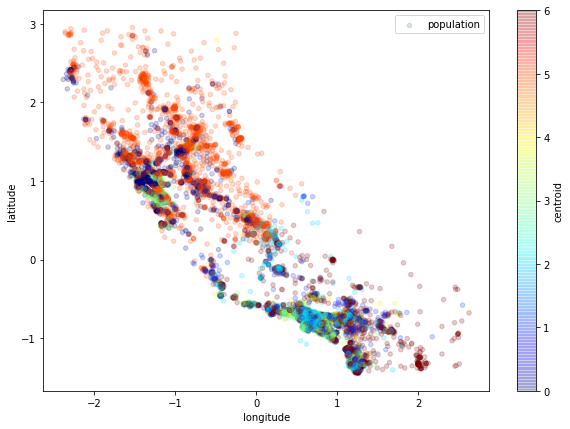

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_4_7[1], values_4_7[2])
sse = get_sse(housing_prepared, values_4_7[1])
housing_df['centroid'] = values_4_7[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_4_7[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_4_8 = k_means(housing_prepared, 8, 4, 0)

[array([3.94121163e+04, 3.45818683e+04, 3.81709095e+04, 1.90929477e+04,
       1.88309781e+04, 1.95937031e+04, 1.87891119e+04, 1.84766989e+04,
       5.83798211e+03, 3.58548577e+03, 2.00000000e+00, 3.51931221e+03,
       1.85228099e+03]), array([3.16273393e+04, 3.90282329e+04, 2.38315224e+04, 1.67125871e+04,
       1.67651282e+04, 1.70681702e+04, 1.68668288e+04, 1.77475082e+04,
       5.18623420e+03, 5.23479914e+03, 2.00000000e+00, 1.64057590e+03,
       1.90862136e+03]), array([1.84215437e+04, 1.75204191e+04, 4.21471493e+04, 3.46330932e+05,
       3.25028653e+05, 3.02765821e+05, 3.21294778e+05, 1.81232038e+04,
       4.08855814e+03, 3.83579070e+03, 2.00000000e+00, 1.68302907e+03,
       1.87527907e+03]), array([1.92786663e+04, 1.72553805e+04, 1.89531500e+04, 1.70145296e+04,
       1.74991404e+04, 1.70425718e+04, 1.71926229e+04, 9.65985508e+04,
       4.24775737e+03, 4.13618645e+03, 2.00000000e+00, 1.71569402e+03,
       1.85293296e+03]), array([2.49360815e+04, 2.58058097e+04, 2.700876

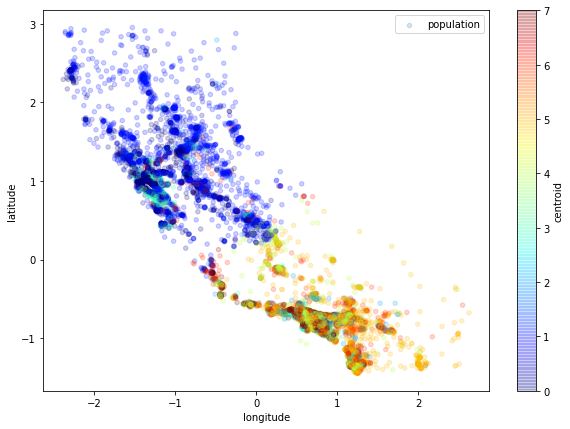

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_4_8[1], values_4_8[2])
sse = get_sse(housing_prepared, values_4_8[1])
housing_df['centroid'] = values_4_8[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_4_8[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_4_9 = k_means(housing_prepared, 9, 4, 0)

[array([1.65870075e+04, 1.73683041e+04, 1.84494559e+04, 1.69709962e+04,
       1.77687940e+04, 1.73108030e+04, 1.74853165e+04, 1.16446966e+05,
       4.57074449e+03, 4.31906815e+03, 2.00000000e+00, 1.64170919e+03,
       1.86355819e+03]), array([2.32646357e+04, 2.64552545e+04, 2.06813617e+04, 1.78315359e+04,
       1.94689357e+04, 1.89211061e+04, 1.90523400e+04, 2.35544911e+04,
       5.86394567e+03, 4.76281047e+03, 2.00000000e+00, 1.79453132e+03,
       1.87001796e+03]), array([3.65871036e+04, 3.39945456e+04, 2.50213297e+04, 1.71426849e+04,
       1.67304199e+04, 1.66284635e+04, 1.68075458e+04, 1.75739506e+04,
       4.29317323e+03, 3.67511883e+03, 2.00000000e+00, 1.73898412e+03,
       1.87046596e+03]), array([1.82387276e+04, 1.73903394e+04, 4.30513746e+04, 3.71546125e+05,
       3.48876373e+05, 3.23927539e+05, 3.45822001e+05, 1.80865380e+04,
       4.09220118e+03, 3.85086144e+03, 2.00000000e+00, 1.67805523e+03,
       1.88004142e+03]), array([3.12047756e+04, 2.90228172e+04, 2.591133

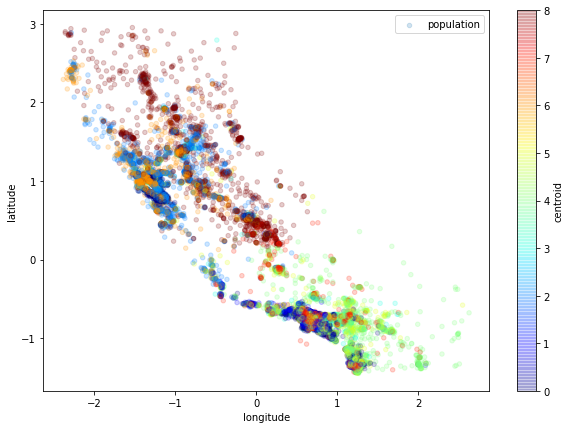

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_4_9[1], values_4_9[2])
sse = get_sse(housing_prepared, values_4_9[1])
housing_df['centroid'] = values_4_9[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_4_9[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [ ]:
# k_means arguments:
# arg0=data
# arg1=k
# arg2=[1=minkowski, 2=manhattan, 3=euclidean, 4=sup]
# arg3=[p if minkowski, else 0]

values_4_10 = k_means(housing_prepared, 10, 4, 0)

[array([2.35565475e+04, 2.65681868e+04, 2.30425573e+04, 1.81841067e+04,
       1.95772329e+04, 1.91888545e+04, 1.91769856e+04, 2.21142514e+04,
       6.67983945e+03, 4.74150207e+03, 2.00000000e+00, 1.84700000e+03,
       1.85806490e+03]), array([3.95527786e+04, 4.21282633e+04, 2.12551182e+04, 1.65897293e+04,
       1.65149311e+04, 1.65274630e+04, 1.65192929e+04, 1.65432671e+04,
       4.50462157e+03, 3.88969779e+03, 2.00000000e+00, 1.69483146e+03,
       1.86640493e+03]), array([2.08252299e+04, 2.73866143e+04, 2.69467305e+04, 1.88917160e+04,
       1.87194151e+04, 1.93679400e+04, 1.94561373e+04, 2.24131344e+04,
       6.13759598e+03, 7.73689769e+03, 2.00000000e+00, 1.70860813e+03,
       1.96493743e+03]), array([2.99868037e+04, 2.88067676e+04, 1.66355598e+04, 1.74603264e+04,
       1.65828598e+04, 1.65120169e+04, 1.65911166e+04, 2.18038807e+04,
       4.13058299e+03, 3.61515002e+03, 2.00080064e+00, 1.84700000e+03,
       1.99464103e+03]), array([1.93972798e+04, 1.92971887e+04, 2.575528

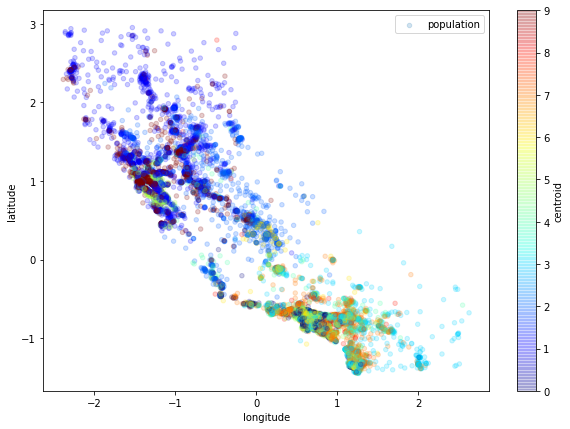

In [ ]:
# gettting standard deviation, sum squared error, set centroid labels

std_dev = get_std_dev(housing_prepared, values_4_10[1], values_4_10[2])
sse = get_sse(housing_prepared, values_4_10[1])
housing_df['centroid'] = values_4_10[0]

# plot result (sum squared error, standard deviation, and mean for each feature)

print(sse)
print(std_dev)
print(values_4_10[1])

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, label="population", figsize=(10,7),
    c="centroid", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

- - -
## Step 4: Concluding Comments on the California Housing Crisis

This question is a qualitative one, and is intended to experiment with a real world clustering task. Hopefully it gives some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).


The k means algorithm was a unique and insightful means to frame this problem. Clearly the higher the cluster count the more nuanced the visual narrative of the problem became. However, there was a sweet spot that depending on which distance calculation, was before 10 clusters. For example, with the euclidean distance at 8 or 9 centroids, the coastal areas were highlighted into one similar cluster, although at 10 this was too visually convoluted to see. This was a useful algorithm in visualizing the discrepencies between housing cost, but many questions remain unanswerable by data analysis, even if it is a machine learning algorithm. The gap between eastern california desert and farmland and the western coast is great, culturally, economically, and technologically. The housing prices have at times either bubbled due to demand, or buckled due to poor political policies. These factors play a deep role in future predictions. Will major companies continue to leave coastal California in the next decade due to skyrocketing crime and taxation? Or will the latter not happen and California continue to rise as a technological empire?